# <span style="color:red; font-style:italic">CEE et Réformes Fiscales en Belgique :</span> <span style="color:red; font-weight:bold; font-style:italic">Les Liens Inévitables</span>

### <span style="color:green">Imports </span> 

In [1]:
# Tous les imports liés cà notre thématique 
# Extraction de keywords
import random
import os
import yake
import collections
# WordCloud et stopwords
from collections import Counter
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
from PIL import Image
import PIL.Image
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.util import bigrams, trigrams
from nltk import FreqDist
from IPython.display import Image 
from IPython.display import display
from IPython.display import display, HTML
# Clustering et Word2Vec
import string
from gensim import models
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from unidecode import unidecode
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
# SpaCy
import sys
from collections import defaultdict
import spacy
from spacy.lang.fr.examples import sentences
nlp = spacy.load('fr_core_news_md')
# Graphes et tableaux
import matplotlib.pyplot as plt
import numpy as np
from os import path, getcwd
import re
import matplotlib as mpl
from tabulate import tabulate
from numpy import zeros,array
import pandas as pd
from pprint import pprint
# Sentiment analysis
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Imen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Imen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## <span style="color:blue">Préparation du corpus </span> 

### <span style="color:green">Stocker tout le contenu des journaux dans des fichiers temporaires </span> 

In [2]:
# Définir les chemins des journaux
paths = ["../data/le_soir", "../data/le_drapeau_rouge", "../data/la_libre_belgique"]

# Définir les listes pour chaque journal
le_soir_list = []
le_drapeau_rouge_list = []
la_libre_belgique_list = []

# Liste pour chaque journal
journal_lists = {"le_soir": le_soir_list, "le_drapeau_rouge": le_drapeau_rouge_list, "la_libre_belgique": la_libre_belgique_list}

# Mapping des journaux et de leurs noms de fichier correspondants
journal_mapping = {"le_soir": "JB838", "le_drapeau_rouge": "JB1051", "la_libre_belgique": "JB427"}

# Boucle sur chaque chemin dans la liste
for path in paths:
    files = sorted(os.listdir(path))

    # Boucle sur les fichiers
    for txt in files:
        file_path = os.path.join(path, txt)
        if os.path.exists(file_path) and os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                # Stocker le contenu des journaux dans leurs listes respectives
                for journal_key, journal_code in journal_mapping.items():
                    if journal_code.lower() in txt.lower():
                        # Ajouter le contenu au journal approprié
                        journal_lists[journal_key].append(content)

# Ecrire tout le contenu des journaux dans des fichiers temporaires
temp_path = '../data/tmp'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)

# Boucle pour écrire dans les fichiers temporaires
for name, journal_list in journal_lists.items():
    with open(os.path.join(temp_path, f'{name}.txt'), 'w', encoding='utf-8') as f:
        f.write(' '.join(journal_list))

# Fonction pour compter le nombre de fichiers dans un dossier
def count_files_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Boucle sur chaque chemin dans la liste
for path in paths:
    num_files = count_files_in_folder(path)
    print(f"Nombre de fichiers dans {os.path.basename(path)}: {num_files}")


Nombre de fichiers dans le_soir: 363
Nombre de fichiers dans le_drapeau_rouge: 606
Nombre de fichiers dans la_libre_belgique: 1569


### <span style="color:green">Nettoyer les fichiers à l'aide d'une fonction de nettoyage et afficher les mots les plus fréquents </span> 

In [3]:
# Chemin du dossier contenant les listes de journaux
tmp_path = '../data/tmp'
files = os.listdir(tmp_path)

# Dossier de sortie pour les fichiers nettoyés
clean_path = '../data/clean'
if not os.path.exists(clean_path):
    os.makedirs(clean_path)

# Charger les stopwords
sw = set(stopwords.words("french"))
custom_stopwords = [ "les", "plus", "cette", "faire", "deux", "bien", "après", "ainsi", "cet",
       "celle", "entre", "toutes", "pendant", "dire", "plus", "non", "tion", "faut", "trois", 
       "aussi", "dit", "contre", "autres", "van", "het", "autre", "jusqu", "ment", "ville", 
       "alors", "juste", "sujet", "au", "la", "sur", "aucuns", "le", "ta", "tandis", 
       "leur", "tellement", "avant", "là", "tels", "avec", "ma", "tes","avoir", "être",
       "maintenant", "ton", "bon", "car", "mais", "tous", "cela", "cette", "mes", "tout", "ce", 
       "mien", "trop", "moins", "très", "mon", "tu", "mot", "ces", "chaque", "dont", "voient", 
       "même", "vont", "ceux", "ni", "votre", "ci", "nommés", "vous", "tél", "comment", "comme", 
       "notre", "vu", "dans",  "nous", "ça", "des", "ou", "étaient", "dedans", "du", "con", "où", 
       "état", "par",  "étions", "dehors", "parce", "été", "depuis", "pas", "être", "devrait", 
       "peut",  "doit", "peu", "donc", "plupart", "dos", "pour", "début", "pourquoi", "elle",  
       "quand", "elles", "que", "on", "quel", "encore", "quelle", "essai", "leurs", "quelles",  "et", 
       "quels", "est", "qui", "eu", "sa", "fait", "son", "faites", "ses", "fois",  "seulement", 
       "font", "si", "hors", "sien", "ici", "sans", "il", "sont", "ils",  "sous", "je", "soyez"] 
sw.update(custom_stopwords)

# Boucle sur chaque fichier original dans le dossier tmp
for file in files:
    # Construire le chemin du fichier original dans le dossier tmp
    tmp_file_path = os.path.join(tmp_path, file)

    # Construire le chemin du fichier nettoyé dans le dossier clean
    if os.path.exists(tmp_file_path):
        clean_file_name = f'clean_{os.path.basename(file)}'
        clean_file_path = os.path.join(clean_path, clean_file_name)

        # Nettoyer le contenu du fichier original et créer le fichier nettoyé
        with open(tmp_file_path, 'r', encoding='utf-8') as original_file:
            original_text = original_file.read()

            # Tokenization
            words = nltk.wordpunct_tokenize(original_text)

            # Eliminer les stopwords et les termes non alphabétiques
            kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
            fdist = nltk.FreqDist(kept)

            # Écrire le contenu nettoyé dans le dossier de sortie
            with open(clean_file_path, 'w', encoding='utf-8') as cleaned_file:
                cleaned_file.write(' '.join(kept))

        # Afficher les mots les plus fréquents dans chaque journal
        print(f"Mots les plus fréquents dans {os.path.basename(clean_file_path)}:", fdist.most_common(10))
        print("--")


Mots les plus fréquents dans clean_la_libre_belgique.txt: [('rue', 17350), ('bruxelles', 15625), ('gouvernement', 12592), ('ministre', 12278), ('francs', 11013), ('pays', 9643), ('notaire', 9205), ('belgique', 9188), ('prix', 9131), ('heures', 8532)]
--
Mots les plus fréquents dans clean_le_drapeau_rouge.txt: [('gouvernement', 3921), ('pays', 3643), ('parti', 3208), ('politique', 2966), ('ministre', 2853), ('travailleurs', 2653), ('guerre', 2388), ('belgique', 2349), ('travail', 2339), ('bruxelles', 2157)]
--
Mots les plus fréquents dans clean_le_soir.txt: [('bruxelles', 3511), ('rue', 3361), ('ministre', 3049), ('prix', 2833), ('pays', 2586), ('gouvernement', 2525), ('loi', 2251), ('cours', 2191), ('millions', 1984), ('projet', 1910)]
--


### <span style="color:green">Afficher des mots les plus fréquents en relation avec les taxes dans un tableau simplifié </span> 


In [4]:
# Chemin du dossier contenant les fichiers nettoyés
clean_path = '../data/clean'
files = os.listdir(clean_path)

# Mots-clés liés aux taxes
tax_keywords = ["taxe", "impôt", "fiscalité", "contribution", "déclaration",
                "taxes", "impôts", "fiscalités", "contributions", "déclarations",
                "biens collectifs purs", "bien collectif pur", "bas salaire", "bas salires",
                "coins fiscaux", "coins sociaux", "dépenses publiques", "complémentarités", "redistribution",
                "complémentarité", "abattement", "abbatements","accise", "aléa moral", "anti sélection", "coin fiscalo-social"
                "assiette fiscale","assiettes fiscales", "biens publics", "bien public", "déficits budgétaires",
                "déficit budgétaire", "dettes publiques", "impôt familialisé", "impôt familialisé", 
                "impôt sur le bénéfice des sociétés", "impôts", "fiscal", "fiscaux", "fiscalité", "fiscalités",
                "taxe fiscale", "taxes fiscales", "taxe de produit", "taxes de produit"]

# Initialiser une liste pour stocker les résultats
result_data = []

# Dictionnaire pour stocker les fréquences des mots liés aux taxes
tax_freq_dict = {}

# Boucle sur chaque fichier nettoyé
for file in files:
    file_path = os.path.join(clean_path, file)
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()

        # Tokenization
        words = nltk.wordpunct_tokenize(text)

        # Filtrer les mots liés aux taxes
        tax_related_words = [w.lower() for w in words if w.lower() in map(str.lower, tax_keywords)]

        # Mettre à jour le dictionnaire des fréquences
        for word in tax_related_words:
            if word in tax_freq_dict:
                tax_freq_dict[word] += 1
            else:
                tax_freq_dict[word] = 1

        # Ajouter une nouvelle ligne à la liste
        result_data.append({"Journal": os.path.splitext(file)[0], **tax_freq_dict})

# Créer un DataFrame à partir de la liste
result_df = pd.DataFrame(result_data)

# Remplacer les valeurs NaN par 0
result_df = result_df.fillna(0)

# Afficher le DataFrame sous forme de tableau markdown
print(result_df.to_markdown(index=False))

| Journal                 |   impôts |   impôt |   fiscal |   taxes |   taxe |   déclaration |   contributions |   accise |   déclarations |   contribution |   fiscaux |   fiscalité |   abattement |   fiscalités |   redistribution |   complémentarité |
|:------------------------|---------:|--------:|---------:|--------:|-------:|--------------:|----------------:|---------:|---------------:|---------------:|----------:|------------:|-------------:|-------------:|-----------------:|------------------:|
| clean_la_libre_belgique |     5337 |    2851 |      781 |    2596 |   3904 |          1693 |            1176 |      141 |            829 |            690 |       357 |         546 |           21 |            4 |               11 |                 0 |
| clean_le_drapeau_rouge  |     6423 |    3091 |      851 |    3328 |   4408 |          2201 |            1215 |      142 |           1004 |            782 |       391 |         651 |           34 |            4 |               17 |         

### <span style="color:green">Comparaison des mots fréquents dans 'Le Soir' et 'Le Drapeau Rouge'</span> 


In [5]:
# Chemin du dossier contenant les fichiers nettoyés
clean_path = '../data/clean'
selected_journals = ["le_soir", "le_drapeau_rouge"]

# Initialiser une liste pour stocker les résultats
result_data = []

# Mots-clés liés aux taxes
integration_keywords = ["CEE", "cee", "communauté économique européenne", "intégration européenne", "union européenne",
                        "marché commun", "traité de rome", "libre circulation", "politique agricole commune",
                        "coopération européenne", "élargissement européen", "monnaie unique", "zone euro","communauté européenne",
                        "commission européenne", "Parlement européen", "conseil de l'union européenne",
    "réforme institutionnelle", "Pays-Bas", "Luxembourg", "France", "Allemagne","politique agricole commune", 
    "économie européenne", "politique étrangère européenne", "citoyenneté européenne","élargissement européen",
    "accords bilatéraux", "développement européen", "souveraineté partagée", "coopération intergouvernementale",
    "adhésion", "marché unique", "convergence économique", "politique monétaire", "politique de la concurrence",
    "politique régionale", "fonds structurels", "politique de cohésion", "harmonisation", "subsidiarité",
    "gouvernance européenne", "euro", "élargissement de l'ue", "UE", "pacte de stabilité et de croissance",
    "politique étrangère et de sécurité commune", "marché intérieur", "politique sociale européenne",
    "politique environnementale européenne", "acquis communautaire", "Schengen", "schengen", "acier et charbon",
    "politique de voisinage", "eurozone", "libre-échange", "négociations d'adhésion",
    "politique de pêche commune", "politique de transport européenne", "politiques sectorielles européennes",
    "institution européenne", "sommet européen", "déclaration de Messine", "convention de Schengen",
    "espace Schengen", "politique énergétique européenne"]

# Dictionnaire pour stocker les fréquences des mots liés aux taxes
integration_freq_dict = {}

# Boucle sur chaque fichier nettoyé
for file in os.listdir(clean_path):
    file_path = os.path.join(clean_path, file)

    # Filtrer les journaux 
    if any(journal in file for journal in selected_journals):
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()

            # Tokenization
            words = nltk.wordpunct_tokenize(text)

            # Filtrer les mots liés aux taxes
            integration_related_words = [w.lower() for w in words if w.lower() in map(str.lower, integration_keywords)]

            # Mettre à jour le dictionnaire des fréquences
            for word in integration_related_words:
                if word in integration_freq_dict:
                    integration_freq_dict[word] += 1
                else:
                    integration_freq_dict[word] = 1

            # Ajouter une nouvelle ligne à la liste
            result_data.append({"Journal": os.path.splitext(file)[0], **integration_freq_dict})

# Créer un DataFrame à partir de la liste
result_df = pd.DataFrame(result_data)

# Remplacer les valeurs NaN par 0
result_df = result_df.fillna(0)

# Afficher le DataFrame sous forme de tableau markdown
print(result_df.to_markdown(index=False))


| Journal                |   luxembourg |   allemagne |   france |   adhésion |   cee |   euro |   harmonisation |
|:-----------------------|-------------:|------------:|---------:|-----------:|------:|-------:|----------------:|
| clean_le_drapeau_rouge |          296 |         888 |     1258 |         83 |   241 |    142 |              14 |
| clean_le_soir          |          607 |        1481 |     2126 |        138 |   326 |    169 |              45 |


### <span style="color:green">WordCloud</span> 


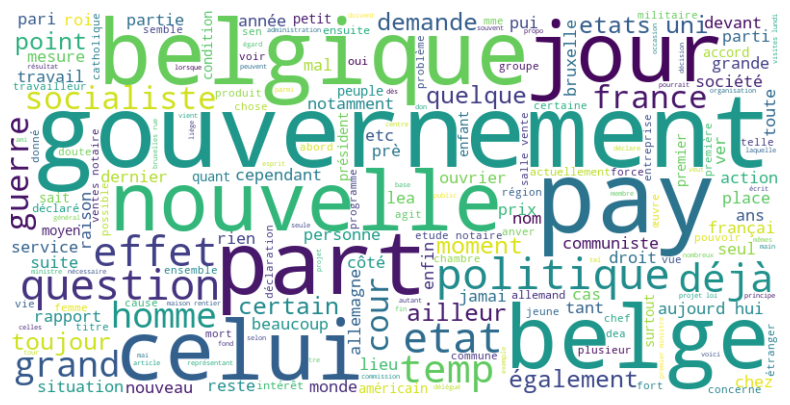

In [6]:
# Chemin du dossier contenant les fichiers nettoyés
clean_path = '../data/clean'
files = os.listdir(clean_path)

# Concaténer tous les textes nettoyés dans une seule chaîne
all_text = ''
for file in files:
    file_path = os.path.join(clean_path, file)
    with open(file_path, 'r', encoding='utf-8') as f:
        all_text += f.read() + ' '

# Générer le WordCloud avec des couleurs
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Afficher le WordCloud en utilisant Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### <span style="color:green">Entités nommées dans les journaux</span> 


### La Libre Belgique

In [7]:
n = 600000
text = open("../data/clean/clean_la_libre_belgique.txt", encoding='utf-8').read()[:n]

# Traiter le texte
doc = nlp(text)

# Compter les entités
personnes_libre = defaultdict(int)
lieux_libre = defaultdict(int)
organisations_libre = defaultdict(int)

for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        personnes_libre[ent.text] += 1
    elif ent.label_ == "LOC" and len(ent.text) > 3:
        lieux_libre[ent.text] += 1
    elif ent.label_ == "ORG" and len(ent.text) > 3:
        organisations_libre[ent.text] += 1

# Trier et imprimer avec Pandas
df_people_libre = pd.DataFrame(sorted(personnes_libre.items(), key=lambda kv: kv[1], reverse=True)[:10], columns=['Personne', 'Fréquence'])
df_places_libre = pd.DataFrame(sorted(lieux_libre.items(), key=lambda kv: kv[1], reverse=True)[:10], columns=['Lieu', 'Fréquence'])
df_orga_libre = pd.DataFrame(sorted(organisations_libre.items(), key=lambda kv: kv[1], reverse=True)[:10], columns=['Organisation', 'Fréquence'])

# Afficher les résultats côte à côte
print("\nEntités nommées dans La Libre Belgique :")
display(HTML("<table><tr><td>{}</td><td>{}</td><td>{}</td></tr></table>".format(
    df_people_libre.to_html(index=False), 
    df_places_libre.to_html(index=False),
    df_orga_libre.to_html(index=False))))




Entités nommées dans La Libre Belgique :


Personne,Fréquence
jacobs,33
wirth,9
alphonse witte,9
theunis,8
lloyd george,8
mustapha kemal,8
léon brasseur,7
tschoffen,6
albert,5
benoît,5


### Le Soir

In [8]:
n = 600000
text = open("../data/clean/clean_le_soir.txt", encoding='utf-8').read()[:n]

# Traiter le texte
doc = nlp(text)

# Compter les entités
personnes_soir = defaultdict(int)
lieux_soir = defaultdict(int)
organisations_soir = defaultdict(int)

for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        personnes_soir[ent.text] += 1
    elif ent.label_ == "LOC" and len(ent.text) > 3:
        lieux_soir[ent.text] += 1
    elif ent.label_ == "ORG" and len(ent.text) > 3:
        organisations_soir[ent.text] += 1

# Trier et imprimer avec Pandas
df_people_soir = pd.DataFrame(sorted(personnes_soir.items(), key=lambda kv: kv[1], reverse=True)[:10], columns=['Personne', 'Fréquence'])
df_places_soir = pd.DataFrame(sorted(lieux_soir.items(), key=lambda kv: kv[1], reverse=True)[:10], columns=['Lieu', 'Fréquence'])
df_orga_soir = pd.DataFrame(sorted(organisations_soir.items(), key=lambda kv: kv[1], reverse=True)[:10], columns=['Organisation', 'Fréquence'])

# Afficher les résultats côte à côte
print("\nEntités nommées dans Le soir après 1958:")
display(HTML("<table><tr><td>{}</td><td>{}</td><td>{}</td></tr></table>".format(
    df_people_soir.to_html(index=False), 
    df_places_soir.to_html(index=False),
    df_orga_soir.to_html(index=False))))




Entités nommées dans Le soir après 1958:


Personne,Fréquence
jacobs,12
von falkenhausen,10
martine,10
hubert,9
jean pierre jacobs,8
mac arthur,8
houtte,7
stafford cripps,7
eisenhower,7
lambert lot,6


### Le Drapeau Rouge

In [9]:
n = 600000
text = open("../data/clean/clean_le_drapeau_rouge.txt", encoding='utf-8').read()[:n]

# Traiter le texte
doc = nlp(text)

# Compter les entités
personnes_drapeau = defaultdict(int)
lieux_drapeau = defaultdict(int)
organisations_drapeau = defaultdict(int)

for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        personnes_drapeau[ent.text] += 1
    elif ent.label_ == "LOC" and len(ent.text) > 3:
        lieux_drapeau[ent.text] += 1
    elif ent.label_ == "ORG" and len(ent.text) > 3:
        organisations_drapeau[ent.text] += 1

# Trier et imprimer avec Pandas
df_people_drapeau = pd.DataFrame(sorted(personnes_drapeau.items(), key=lambda kv: kv[1], reverse=True)[:10], columns=['Personne', 'Fréquence'])
df_places_drapeau = pd.DataFrame(sorted(lieux_drapeau.items(), key=lambda kv: kv[1], reverse=True)[:10], columns=['Lieu', 'Fréquence'])
df_orga_drapeau = pd.DataFrame(sorted(organisations_drapeau.items(), key=lambda kv: kv[1], reverse=True)[:10], columns=['Organisation', 'Fréquence'])

# Afficher les résultats côte à côte
print("\nEntités nommées dans Le Drapeau Rouge après 1958:")
display(HTML("<table><tr><td>{}</td><td>{}</td><td>{}</td></tr></table>".format(
    df_people_drapeau.to_html(index=False), 
    df_places_drapeau.to_html(index=False),
    df_orga_drapeau.to_html(index=False))))


Entités nommées dans Le Drapeau Rouge après 1958:


Personne,Fréquence
léopold iii,23
edgar lalmand,17
jean borremans,14
julien lahaut,13
truman,12
henri glineur,11
staline,10
jean terfve,9
eisenhower,9
léopold,8


### <span style="color:green">Vectorisation des document</span> 


In [10]:
data_path = "../data/clean/"
files = [f for f in sorted(os.listdir(data_path))]
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

# Instancier le modèle TF-IDF avec ses arguments
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    lowercase=True)

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`
tfidf_vectors = vectorizer.fit_transform(texts)

c:\Users\Imen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### <span style="color:green">Détection de bigrammes et trigrammes dans les journaux</span> 


### La Libre Belgique

In [16]:
# Charger le texte du journal
file_path = '../data/clean/clean_la_libre_belgique.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# Tokeniser le texte
tokens = word_tokenize(text)

# Supprimer les mots vides
stop_words = set(stopwords.words('french'))
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

# Calculer la distribution de fréquence
freq_dist = FreqDist(filtered_tokens)

# Exclure les mots peu fréquents
min_freq = 5
filtered_tokens = [word for word in filtered_tokens if freq_dist[word] >= min_freq]

# Générer des bigrammes et trigrammes
bigram_model_libre = list(bigrams(filtered_tokens))
trigram_model_libre = list(trigrams(filtered_tokens))

# Afficher les 20 premiers bigrammes
print("Les 20 premiers bigrammes sont :", bigram_model_libre[:20])

# Afficher les 20 premiers trigrammes
print("Les 20 premiers trigrammes sont :", trigram_model_libre[:20])


Les 20 premiers bigrammes sont : [('nomination', 'député'), ('député', 'permanent'), ('permanent', 'muller'), ('muller', 'solution'), ('solution', 'intervienne'), ('intervienne', 'justifie'), ('justifie', 'accusations'), ('accusations', 'portées'), ('portées', 'lul'), ('lul', 'établisse'), ('établisse', 'inanité'), ('inanité', 'aille'), ('aille', 'cause'), ('cause', 'flamande'), ('flamande', 'rien'), ('rien', 'gagner'), ('gagner', 'politique'), ('politique', 'malheureusement'), ('malheureusement', 'oours'), ('oours', 'der')]
Les 20 premiers trigrammes sont : [('nomination', 'député', 'permanent'), ('député', 'permanent', 'muller'), ('permanent', 'muller', 'solution'), ('muller', 'solution', 'intervienne'), ('solution', 'intervienne', 'justifie'), ('intervienne', 'justifie', 'accusations'), ('justifie', 'accusations', 'portées'), ('accusations', 'portées', 'lul'), ('portées', 'lul', 'établisse'), ('lul', 'établisse', 'inanité'), ('établisse', 'inanité', 'aille'), ('inanité', 'aille', 'c

### Le Soir

In [17]:
# Charger le texte du journal
file_path = '../data/clean/clean_le_soir.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# Tokeniser le texte
tokens = word_tokenize(text)

# Supprimer les mots vides
stop_words = set(stopwords.words('french'))
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

# Calculer la distribution de fréquence
freq_dist = FreqDist(filtered_tokens)

# Exclure les mots peu fréquents 
min_freq = 5
filtered_tokens = [word for word in filtered_tokens if freq_dist[word] >= min_freq]

# Générer des bigrammes et trigrammes
bigram_model_soir = list(bigrams(filtered_tokens))
trigram_model_soir = list(trigrams(filtered_tokens))

# Afficher les 20 premiers bigrammes
print("Les 20 premiers bigrammes sont :", bigram_model_soir[:20])

# Afficher les 20 premiers trigrammes
print("Les 20 premiers trigrammes sont :", trigram_model_soir[:20])


Les 20 premiers bigrammes sont : [('jeudi', 'janvier'), ('janvier', 'soir'), ('soir', 'conseil'), ('conseil', 'guerre'), ('guerre', 'bruxelles'), ('bruxelles', 'laceba'), ('laceba', 'cinq'), ('cinq', 'ans'), ('ans', 'bastin'), ('bastin', 'coppieters'), ('coppieters', 'isserentant'), ('isserentant', 'troisième'), ('troisième', 'chambre'), ('chambre', 'réfractaires'), ('réfractaires', 'rendu'), ('rendu', 'mercredi'), ('mercredi', 'jugement'), ('jugement', 'cause'), ('cause', 'dirigeants'), ('dirigeants', 'société')]
Les 20 premiers trigrammes sont : [('jeudi', 'janvier', 'soir'), ('janvier', 'soir', 'conseil'), ('soir', 'conseil', 'guerre'), ('conseil', 'guerre', 'bruxelles'), ('guerre', 'bruxelles', 'laceba'), ('bruxelles', 'laceba', 'cinq'), ('laceba', 'cinq', 'ans'), ('cinq', 'ans', 'bastin'), ('ans', 'bastin', 'coppieters'), ('bastin', 'coppieters', 'isserentant'), ('coppieters', 'isserentant', 'troisième'), ('isserentant', 'troisième', 'chambre'), ('troisième', 'chambre', 'réfractai

### Le Drapeau Rouge

In [18]:
# Charger le texte du journal
file_path = '../data/clean/clean_le_drapeau_rouge.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# Tokeniser le texte
tokens = word_tokenize(text)

# Supprimer les mots vides
stop_words = set(stopwords.words('french'))
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

# Calculer la distribution de fréquence
freq_dist = FreqDist(filtered_tokens)

# Exclure les mots peu fréquents 
min_freq = 5
filtered_tokens = [word for word in filtered_tokens if freq_dist[word] >= min_freq]

# Générer des bigrammes et trigrammes
bigram_model_drapeau = list(bigrams(filtered_tokens))
trigram_model_drapeau = list(trigrams(filtered_tokens))

# Afficher les 20 premiers bigrammes
print("Les 20 premiers bigrammes sont :", bigram_model_drapeau[:20])

# Afficher les 20 premiers trigrammes
print("Les 20 premiers trigrammes sont :", trigram_model_drapeau[:20])


Les 20 premiers bigrammes sont : [('mam', 'vendredi'), ('vendredi', 'janvier'), ('janvier', 'gauche'), ('gauche', 'droite'), ('droite', 'parti'), ('parti', 'communiste'), ('communiste', 'finlande'), ('finlande', 'enregistré'), ('enregistré', 'dernières'), ('dernières', 'élections'), ('élections', 'appréciable'), ('appréciable', 'succès'), ('succès', 'succès'), ('succès', 'entendu'), ('entendu', 'donné'), ('donné', 'mat'), ('mat', 'ventre'), ('ventre', 'journaux'), ('journaux', 'réactionnaires'), ('réactionnaires', 'expliquer')]
Les 20 premiers trigrammes sont : [('mam', 'vendredi', 'janvier'), ('vendredi', 'janvier', 'gauche'), ('janvier', 'gauche', 'droite'), ('gauche', 'droite', 'parti'), ('droite', 'parti', 'communiste'), ('parti', 'communiste', 'finlande'), ('communiste', 'finlande', 'enregistré'), ('finlande', 'enregistré', 'dernières'), ('enregistré', 'dernières', 'élections'), ('dernières', 'élections', 'appréciable'), ('élections', 'appréciable', 'succès'), ('appréciable', 'suc

### <span style="color:green">Word Embeddings : le modèle Word2Vec</span> 


In [21]:
from gensim.models.phrases import Phrases, Phraser
from unidecode import unidecode

# Création des bigrammes et trigrammes
def create_ngrams(sentences):
    bigram_model = Phrases(sentences, min_count=5, threshold=10)
    trigram_model = Phrases(bigram_model[sentences], min_count=5, threshold=10)
    bigram_phraser = Phraser(bigram_model)
    trigram_phraser = Phraser(trigram_model)
    return bigram_phraser, trigram_phraser

# Création d'un objet qui stream les lignes d'un fichier pour économiser de la RAM
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

# Chemins des fichiers
file_paths = ['../data/clean/clean_le_drapeau_rouge.txt', '../data/clean/clean_le_soir.txt', '../data/clean/clean_la_libre_belgique.txt']

# Création du dossier de sortie "journaux" 
output_folder = '../data/journaux'
os.makedirs(output_folder, exist_ok=True)

# Boucle sur chaque fichier
for file_path in file_paths:
    # Création de l'objet MySentences
    sentences = MySentences(file_path)

    # Création des bigrammes et trigrammes
    bigram_phraser, trigram_phraser = create_ngrams(sentences)

    # Entrainement d'un modèle Word2Vec sur ce corpus avec bigrammes et trigrammes
    model = Word2Vec(
        trigram_phraser[bigram_phraser[sentences]], 
        vector_size=32,
        window=5,
        min_count=5,
        workers=4,
        epochs=5
    )

    # Nom du modèle avec le nouveau dossier "journaux"
    output_file = os.path.join(output_folder, os.path.basename(file_path).replace('.txt', '_model.bin'))

    # Sauvegarde du modèle dans le nouveau dossier
    model.save(output_file)


### <span style="color:green">Calculer la similarité entre deux mots dans les journaux</span> 


In [25]:
# Tous les fichiers journaux
models_folder = '../data/journaux/'
model_files = [file for file in os.listdir(models_folder) if file.endswith('_model.bin')]
models = [Word2Vec.load(os.path.join(models_folder, file)) for file in model_files]

# Mots à comparer
pairs_to_compare = [
    ("fiscalite", "taxe"),
    ("declaration", "impots"),
    ("fiscal", "accise"),
    ("abattement", "redistribution"),
    ("belgique", "cee"),
    ("belgique", "CEE"),
    ("ouvriers", "wallonie"),
    ("travail", "salaire"),
    ("catholique", "liberal"),
    ("catholique", "socialiste"),
    ("liberal", "socialiste")]

# Calculer la similarité pour chaque paire de mots pour chaque modèle
for model, file in zip(models, model_files):
    print(f"Similarité pour le modèle {file}:")
    for word1, word2 in pairs_to_compare:
        if word1 in model.wv.key_to_index and word2 in model.wv.key_to_index:
            similarity_score = model.wv.similarity(word1, word2)
            print(f"Similarité entre '{word1}' et '{word2}': {similarity_score}")
        else:
            print(f"L'un des mots entre '{word1}' et '{word2}' n'est pas présent dans le vocabulaire du modèle.")
    print("---")

Similarité pour le modèle clean_la_libre_belgique_model.bin:
Similarité entre 'fiscalite' et 'taxe': -0.114939384162426
Similarité entre 'declaration' et 'impots': 0.1726250797510147
Similarité entre 'fiscal' et 'accise': -0.20616286993026733
Similarité entre 'abattement' et 'redistribution': -0.1947333812713623
Similarité entre 'belgique' et 'cee': 0.03606940060853958
L'un des mots entre 'belgique' et 'CEE' n'est pas présent dans le vocabulaire du modèle.
Similarité entre 'ouvriers' et 'wallonie': 0.08437817543745041
Similarité entre 'travail' et 'salaire': 0.0946330800652504
Similarité entre 'catholique' et 'liberal': 0.019034530967473984
Similarité entre 'catholique' et 'socialiste': -0.1590864658355713
Similarité entre 'liberal' et 'socialiste': -0.045788004994392395
---
Similarité pour le modèle clean_le_drapeau_rouge_model.bin:
Similarité entre 'fiscalite' et 'taxe': 0.08770470321178436
Similarité entre 'declaration' et 'impots': 0.046736761927604675
L'un des mots entre 'fiscal' 

### <span style="color:green">Calculer la similarité de mots proches</span> 


In [26]:
# Tous les jounnaux
models_folder = '../data/journaux/'
model_files = [file for file in os.listdir(models_folder) if file.endswith('_model.bin')]

# Mots à comparer
words_to_compare = ["france", "cee", "euro", "allemagne", "adhesion", "fiscal", "taxe", "impots"]

# Calculer les mots les plus similaires pour chaque modèle
for model, file in zip(models, model_files):
    print(f"Mots les plus similaires pour le modèle {file}:")
    for word in words_to_compare:
        if word in model.wv.key_to_index:
            most_similar_words = model.wv.most_similar(word)
            print(f"Les mots les plus similaires à '{word}': {most_similar_words}")
        else:
            print(f"Le mot '{word}' n'est pas présent dans le vocabulaire du modèle.")
    print("---")


Mots les plus similaires pour le modèle clean_la_libre_belgique_model.bin:
Les mots les plus similaires à 'france': [('tergiverser', 0.6863304376602173), ('insinuations', 0.6829160451889038), ('premiere_sortie', 0.6745169758796692), ('centiares_portee', 0.6697620153427124), ('aubepine', 0.6636319160461426), ('sollicitee', 0.66156405210495), ('expirant_septembre', 0.6469628810882568), ('atelier_timbre', 0.6402664184570312), ('ssss', 0.6346524357795715), ('conseil_superieur_agriculture', 0.6317296624183655)]
Les mots les plus similaires à 'cee': [('substantiel', 0.685594916343689), ('critique_severe', 0.6587812304496765), ('grou', 0.6512735486030579), ('nettoyeur', 0.6465502977371216), ('forts', 0.6464438438415527), ('kuo', 0.6398754119873047), ('beauvals', 0.6388912200927734), ('probleme_scolaire', 0.62038654088974), ('sollicitaient', 0.6191011071205139), ('suivant_formule', 0.610539436340332)]
Les mots les plus similaires à 'euro': [('commission_fiscale', 0.6715641021728516), ('rendeme